# Delta Hedging 


Delta hedging is the process of offsetting price flucuations in an options contract by trading in the underlying. 
In this notebook, we will show how one can use delta hedging to hedge fluctuations in a short call of Apple stock. 
In this case, we are the seller of the option and are therefore obligated to sell the stock at the strike price if the buyer of the option chooses to exercise the option. Thus, we need to ensure that our position such that if the contract expires in the money, we will be able to pay. 
In this case, you would buy or sell shares of the underlying stock to offset the price changes in a particular options price.

### The data 
Here we will use dataset pulled down by Yahoo finance for the date of 20/07/2023. We will use the closing price of the stock for the day as the spot price for the option.

### The model
Here we will simply use the Black Scholes model of European options. I realise that the Heston model might be better to incorporate the volatility smile, but for the time being, we will use the Black Scholes model.

In [66]:
import numpy as np
import pandas as pd
import datetime as dt
from _utils import *
from _fitting import *
import matplotlib.pyplot as plt
import plotly.graph_objects as go


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Let's first pull down some stock data for Apple

In [74]:
# tickers for the Apple
ticker = "AAPL"
option_ticker = "AAPL"

interval = "1d"
end_date = dt.datetime(2023, 7, 20)
start_date = end_date -  dt.timedelta(days = 300)

# Get yesterdays price data for the S&P 500
data = get_stock_data(ticker, start_date, end_date, interval)
data.index = data.index.date

#------------------------------------------#
Getting underlying data for ticker:  AAPL
#------------------------------------------#
[*********************100%***********************]  1 of 1 completed


In [75]:
# We first want to estimate the realized volatility of the stock
# We now want to get the realised volatility over the last 30 days (21 trading days)
data['log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
data['volatility'] = data['log_return'].rolling(10).std() * np.sqrt(252)


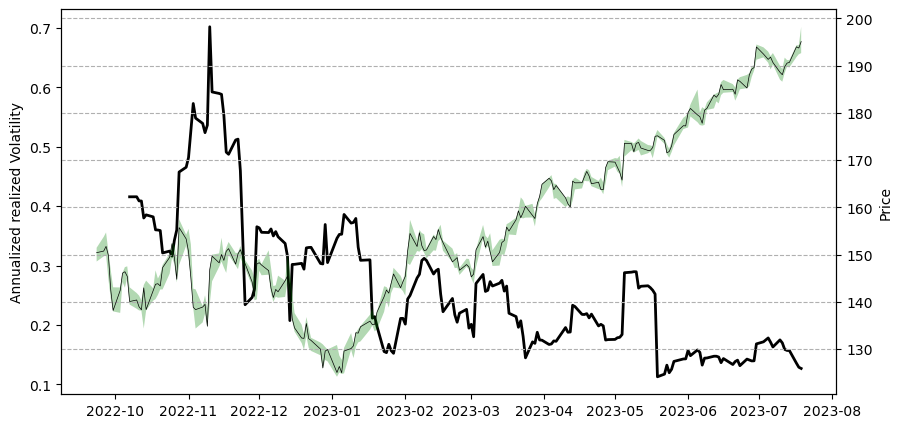

In [76]:
# Plot the volatility
fig = plt.figure(figsize=(10, 5))
plt.plot(data['volatility'], color='k', linewidth=2)
plt.ylabel('Annualized realized Volatility')

# on seperate axis plot the price
ax2 = plt.twinx()
ax2.plot(data['Close'], color='k', linewidth=0.5)
ax2.fill_between(data.index, data['Low'], data['High'], facecolor='g', alpha=0.3)
ax2.set_ylabel('Price')

plt.grid(linestyle='--')
plt.show()

We can see that since the start of 2023, the realized volatility in the stock has steadly decreased as Apple has been on a steady uptrend. 

# Get Options data and Interest rate data

Here we will be in the business of selling calls options on Apple stock with a 13 week majurity from today. 

We will use the Black-Scholes formula to calculate the price of the option. We will then use the delta hedging strategy to hedge the option weekly. We will then calculate the profit and loss of the option and the hedging strategy.

Recall that a call gives us, the owner the right but not the obligation to purchase the stock at a given price, the strike price, at a given time, the maturity.  The profits we will make on this will be related to the premium we collect, and the potential net positive cash flow we will receive if the stock price is above the strike price at maturity. 

We will also get current repo rate and use that as the risk free rate.

In [493]:
# get expirey date within tau days of yesterday
trading_days = 252
tau = 92
# Number of trading days
tau_trading = 66
dtau = 5

# interest rate per day (repo rate)
r = get_repo_rate(end_date-dt.timedelta(days=7), end_date).values[0,0]/(100)
r_t = r/365

expiry_date = (dt.datetime.today() + dt.timedelta(days=tau)).date()

# load in the options data
options = pd.read_csv('./data/options.csv', index_col=0)

# get at the money price
S0 = data['Close'].values[-1]
    

In [494]:
# get the option that is the closest to the money
idx = np.abs(options.index - 195).argmin()
option = options.iloc[idx]

# We now purchase the option, which controls 100 shares so the price is 
C0 = option['lastPrice']

# get strike price
K = option.name

# we will assume the volatility is the same as the last realised volatility
vol = data['volatility'].values[-1]/(100/tau**0.5)

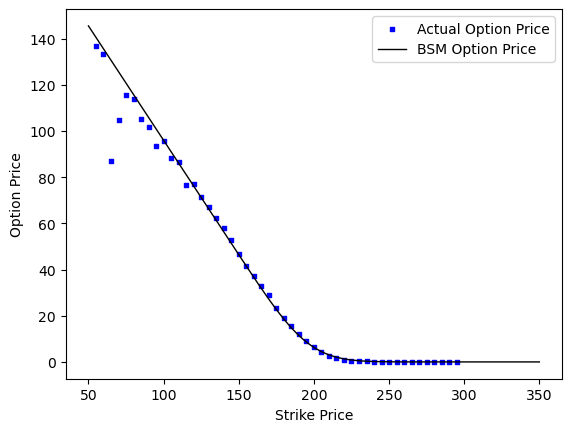

In [495]:
# We will now compare the BSM to the actual options price
K_vals = np.linspace(50, 350, 100)

# Get the call price for different K values
call_price = OptionsPriceBSM(S0, K_vals, tau_trading, vol, r_t, option_type='call')

# Plot the our option price and the BSM option price
plt.scatter(options.index, options['lastPrice'], color='b', s=10, marker='s', label='Actual Option Price')

plt.plot(K_vals, call_price, color='k', linewidth=1, label='BSM Option Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

plt.show()

# Delta Hedging with a single example

Let's first look at a single example of delta hedging. We will use the Black Scholes model to calculate the price of the option. We will then use the delta hedging strategy to hedge the option weekly. We will then calculate the profit and loss of the option and the hedging strategy.

In [511]:
# compute the implied volatility
idx = np.abs(options.index - S0).argmin()
option = options.iloc[idx]

# Set strike price 
K = option.name

# Assuming geometric brownian motion, we can simulate the stock price
t = np.arange(10e-4, tau_trading+dtau, dtau) 


In [512]:
# Compute stock price evolution
St = stockprice_evolution(S0, t, dtau, 0.000, vol, 1)

# Compute the options price evolution and the change in delta
Ct = OptionsPriceBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = OptionDeltaBSM(St, K, t[::-1], vol, r_t, option_type='call')
deltat = np.round(100*deltat, 0).astype(int)

# compute delta adjustments 
d_delta = np.diff(deltat, axis=1)

## Computing profit and loss

Now we will compute the profit and loss (here we will assume that each option controls 100 shares of Apple). There are several quantities that factor into this:
1. The initial premium we collect from selling the option $C_{0}$
2. The net difference between our initial hedge and the final amount we receive from selling the stock, either from the option being exercised or from the hedge being closed out.
3. The net cashflow we receive from maintaining the hedge.

Furthermore there are additional interest payments that we must account for as well, these include:
1. The interest we must pay back to the broker for borrowing the stock to hedge our position.
2. The interest on our cashflow from the hedge.


In [513]:
# Compute everything in a pandas dataframe 
# create a dataframe to store the data with index name as week 
df = pd.DataFrame(index=np.arange(len(t)), columns=['Stock Price', 'Delta'])
df.index.name = 'Week'
df['Stock Price'] = St[0]
df['Delta'] = - deltat[0]
df['Delta Adjustments'] = df['Delta'].diff()
df['Total Delta Adjustment'] = df.loc[0, 'Delta'] - df['Delta']
df['Adjustment Cashflow'] = df['Delta Adjustments']*df['Stock Price']
df['Interest on Adjustment'] = df['Adjustment Cashflow']*(r_t*dtau)

df

,Stock Price,Delta,Delta Adjustments,Total Delta Adjustment,Adjustment Cashflow,Interest on Adjustment
Week,,,,,,
0,195.100006,-56,NaN,0,NaN,NaN
1,183.234377,-31,25.0,-25,4580.859423,3.187776
2,185.909720,-36,-5.0,-20,-929.548601,-0.646864
3,182.646507,-28,8.0,-28,1461.172054,1.016816
4,176.559658,-15,13.0,-41,2295.275556,1.597260
5,191.254312,-45,-30.0,-11,-5737.629363,-3.992761
6,189.687569,-40,5.0,-16,948.437844,0.660009
7,190.808656,-42,-2.0,-14,-381.617312,-0.265564
8,184.532474,-23,19.0,-33,3506.117000,2.439873


In [514]:
# Compute P&L on option
option_premium = 100*Ct[:, 0]
option_interest = 100*Ct[:, 0] * r_t* t[-1]

# Compute cashflow adjustments for delta hedging
d_cashflow = -d_delta*St[:, 1:]

# compute cashfolow adjustments for delta hedging
cashflow = (-d_delta*St[:, 1:]).sum(axis=1)

# Compute profit and loss on stocks hedge
stock_PandL = deltat[:, -1] * K  - deltat[:, 0] * St[:, 0]

# Compute interest on net stock position as borrowed from the money market
stock_interest = (-deltat[0]*St[:, 0] * r_t * dtau).sum()

# Sum all P&L
total_cashflow = option_premium + cashflow + stock_PandL
total_interest = option_interest + stock_interest 

# Return total P&L
total = total_cashflow + total_interest 

print(f'Opiton Premum: {option_premium[0]:.2f}')
print(f'Stock P&L: {stock_PandL[0]:.2f}')
print(f'Adjustment P&L: {cashflow[0]:.2f}')

print(f'Interest on Original P&L: {option_interest[0]:.2f}')
print(f'Interest on Stock P&L: {stock_interest:.2f}')

print(f'Total P&L: {total[0]:.2f}')


Opiton Premum: 890.36
Stock P&L: -10925.60
Adjustment P&L: 9782.86
Interest on Original P&L: 8.67
Interest on Stock P&L: -48.61
Total P&L: -292.32


In [515]:
def MonteCarloPandL(N, S0, K, t, dtau, r, mu, vol_implied, vol_realised, option_type='call'):
    '''
    Compute the P&L of a delta hedged portfolio using Monte Carlo simulation

    ----------
    Parameters
    ----------
    N: int
        Number of simulations
    S0: float
        Initial stock price
    K: float
        Strike price
    t: array_like
        Time to maturity
    dtau: float
        Time step
    r: float
        Interest rate (per trading day)
    mu: float
        Drift of stock price
    vol: float
        Stock measured Volatility
    option_type: str
        Type of option ('call' or 'put')

    -------
    Returns
    -------
    PnL: array_like
        Profit and loss of the portfolio
    
    '''

    # Compute stock price evolution
    St = stockprice_evolution(S0, t, dtau, mu, vol_realised, N)

    # define a function that returns greeks using black scholes
    Ct = OptionsPriceBSM(St, K, t[::-1], vol_implied, r, option_type)
    deltat = OptionDeltaBSM(St, K, t[::-1], vol_implied, r, option_type)
    deltat = np.round(100*deltat, 0).astype(int)

    # compute delta adjustments 
    d_delta = np.diff(deltat, axis=1)
    
    # Compute P&L on option
    option_premium = 100*(Ct[:, 0])

    # Compute interest on option that we say is invested in the money market
    option_interest = 100*Ct[:, 0] *(1- np.exp(-r*t[-1]))

    # compute cashfolow adjustments for delta hedging
    cashflow = (-d_delta*St[:, 1:]).sum(axis=1)

    # Compute profit and loss on stocks hedge
    stock_PandL = K * deltat[:, -1] - deltat[:, 0] * St[:, 0]
    stock_interest = (-deltat[:]*St * r * dtau).sum(axis=1)

    # Sum all P&L
    total_cashflow = option_premium + cashflow + stock_PandL
    total_interest = option_interest + stock_interest 

    # Return total P&L
    return total_cashflow + total_interest, St


In [534]:
PanL, St = MonteCarloPandL(100000, S0, S0, t, dtau, r_t, -0.00, vol, vol, option_type='call')

# Compute mean and standard deviation of P&L
mean = PanL.mean()
std = PanL.std()

# compute 95% confidence interval
conf_int = np.percentile(PanL, [2.5, 97.5])

# compute probbility of loss
prob_loss = np.sum(PanL < 0)/len(PanL)

print(f'P&L mean: {mean:.2f}')
print(f'P&L std: {std:.2f}')
print(f'P&L 95% confidence interval: {conf_int}')
print(f'Probability of loss: {prob_loss:.2f}')

P&L mean: -7.30
P&L std: 180.44
P&L 95% confidence interval: [-394.54562694  346.13236941]
Probability of loss: 0.51


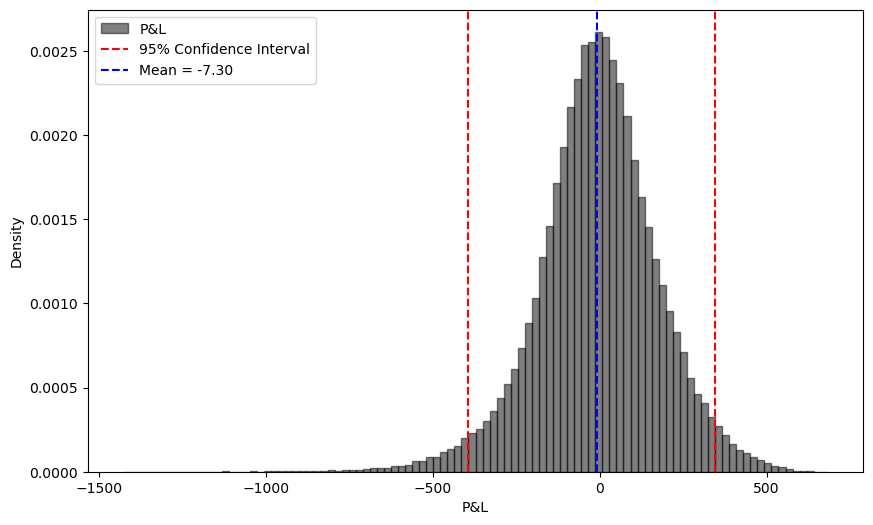

In [535]:
fig = plt.figure(figsize=(10, 6))

plt.hist(PanL, bins=100, density=True, label='P&L', color='k', alpha=0.5, edgecolor='k')

plt.axvline(conf_int[0], color='r', linestyle='--', label='95% Confidence Interval')
plt.axvline(conf_int[1], color='r', linestyle='--')
plt.axvline(mean, color='b', linestyle='--', label='Mean = {:.2f}'.format(mean))
plt.xlabel('P&L')
plt.ylabel('Density')

plt.legend()


plt.show()

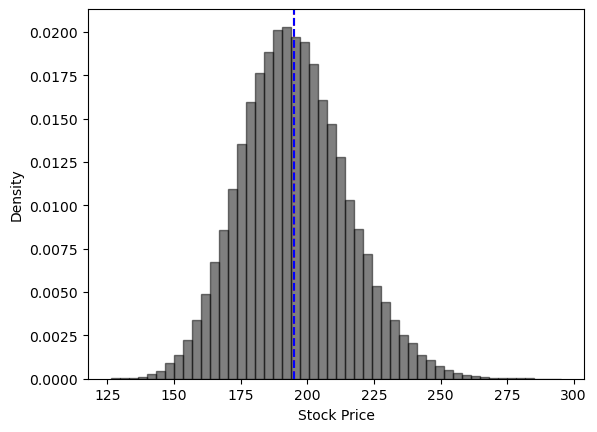

In [522]:
plt.hist(St[:, -1], bins=50, density=True, label='Stock Price', color='k', alpha=0.5, edgecolor='k')
plt.axvline(K, color='r', linestyle='--', label='Strike Price')
plt.axvline(np.mean(St), color='b', linestyle='--', label='Initial Stock Price')
plt.xlabel('Stock Price')
plt.ylabel('Density')
plt.show()